In [1]:
# !pip install fancyimpute

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from dataprocessing import *

In [4]:
df = pd.read_csv("dataset.csv") # dataCleaning.py를 돌린 상태
category_columns = [
            'Location', 'Diagnosis', 'Growth phase', 'Level of invasion', 
            'Histologic subtype', 'Tumor cell type', 'Surgical margin', 'Lymph node', 
            'Precursor lesion', 'tumor_length_category', 'tumor_width_category',
            'tumor_height_category', 'Area of tumor_category',
            'Volume of tumor_category', 'Breslow thickness_category',
            'Mitosis_category'
        ]
numerical_columns = ['Depth of invasion', 'Breslow thickness',
       'tumor_length', 'tumor_width', 'tumor_height', 'Area of tumor',
       'Volume of tumor', 'Mitosis_Value']

In [10]:
df.shape

(245, 26)

In [6]:
df.columns

Index(['Patient_ID', 'Location', 'Diagnosis', 'Growth phase',
       'Level of invasion', 'Histologic subtype', 'Tumor cell type',
       'Surgical margin', 'Lymph node', 'Precursor lesion',
       'tumor_length_category', 'tumor_width_category',
       'tumor_height_category', 'Area of tumor_category',
       'Volume of tumor_category', 'Breslow thickness_category',
       'Mitosis_category', 'Depth of invasion', 'Breslow thickness',
       'tumor_length', 'tumor_width', 'tumor_height', 'Area of tumor',
       'Volume of tumor', 'Mitosis_Value', 'Recurrence'],
      dtype='object')

In [7]:
train, test, category_cols, category_dims, category_indices = TransformDataToTabNet(df, category_columns, numerical_columns, 'means').get_data()

In [9]:
train[0].shape

(25,)

In [5]:
train.shape

(217, 25)

In [5]:
from sklearn.model_selection import train_test_split

# 데이터와 레이블 분리 (예: 'y'가 레이블 칼럼 이름이라고 가정)
X = train[:, :-1]
y = train[:, -1]

# 데이터를 훈련 세트와 검증 세트로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=56)
# y_train = y_train.astype('int64')
# y_valid = y_valid.astype('int64')

X_test = test[:, :]

In [6]:
import torch
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier

# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    cat_idxs=category_indices,
    cat_dims=category_dims,
    cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
    grouped_features=[[9,10,11,12,13]], # you can group features together here
    verbose=10,
)

/home/admin/.conda/envs/maicsh/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [7]:
import os
max_epochs = 2000 if not os.getenv("CI", False) else 2 # 1000


In [8]:
unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=max_epochs , patience=200,
    batch_size=1024, virtual_batch_size=512,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
) 

epoch 0  | loss: 17.71158| val_0_unsup_loss_numpy: 50.57838821411133|  0:00:00s
epoch 10 | loss: 5.60243 | val_0_unsup_loss_numpy: 10.010990142822266|  0:00:00s
epoch 20 | loss: 2.19729 | val_0_unsup_loss_numpy: 2.504879951477051|  0:00:00s
epoch 30 | loss: 1.35442 | val_0_unsup_loss_numpy: 1.8587000370025635|  0:00:00s
epoch 40 | loss: 1.24575 | val_0_unsup_loss_numpy: 1.5739799737930298|  0:00:00s
epoch 50 | loss: 0.95615 | val_0_unsup_loss_numpy: 1.263450026512146|  0:00:01s
epoch 60 | loss: 0.82625 | val_0_unsup_loss_numpy: 1.147089958190918|  0:00:01s
epoch 70 | loss: 0.76004 | val_0_unsup_loss_numpy: 1.0122400522232056|  0:00:01s
epoch 80 | loss: 0.67206 | val_0_unsup_loss_numpy: 0.9148100018501282|  0:00:01s
epoch 90 | loss: 0.69684 | val_0_unsup_loss_numpy: 0.8263800144195557|  0:00:01s
epoch 100| loss: 0.63045 | val_0_unsup_loss_numpy: 0.7798500061035156|  0:00:01s
epoch 110| loss: 0.6661  | val_0_unsup_loss_numpy: 0.7413600087165833|  0:00:02s
epoch 120| loss: 0.61719 | val_0

/home/admin/.conda/envs/maicsh/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [9]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model.predict(X_valid)
assert(reconstructed_X.shape==embedded_X.shape)

In [10]:
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_valid)

In [11]:
# fig, axs = plt.subplots(1, 3, figsize=(20,20))

# for i in range(3):
#     axs[i].imshow(unsupervised_masks[i][:100])
#     axs[i].set_title(f"mask {i}")

In [12]:
unsupervised_model.save_model('./test_pretrain')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./test_pretrain.zip')

/home/admin/.conda/envs/maicsh/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


Successfully saved model at ./test_pretrain.zip


In [13]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-3),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax', # This will be overwritten if using pretrain model
                       verbose=5,
                       cat_emb_dim=3,
                       cat_idxs=category_indices,
                       cat_dims=category_dims,
                       grouped_features=[[9,10,11,12,13]], # you can group features together here
                      )

In [14]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=200,
    batch_size=512, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=loaded_pretrain,
    
) 

/home/admin/.conda/envs/maicsh/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 2.0278  | train_auc: 0.4801  | valid_auc: 0.77412 |  0:00:00s
epoch 5  | loss: 2.00236 | train_auc: 0.48682 | valid_auc: 0.73904 |  0:00:00s
epoch 10 | loss: 1.64318 | train_auc: 0.48173 | valid_auc: 0.74342 |  0:00:00s
epoch 15 | loss: 1.2073  | train_auc: 0.48737 | valid_auc: 0.72588 |  0:00:00s
epoch 20 | loss: 1.16648 | train_auc: 0.49464 | valid_auc: 0.72588 |  0:00:00s
epoch 25 | loss: 1.00859 | train_auc: 0.49518 | valid_auc: 0.76535 |  0:00:00s
epoch 30 | loss: 0.79082 | train_auc: 0.49518 | valid_auc: 0.79167 |  0:00:00s
epoch 35 | loss: 0.80071 | train_auc: 0.50918 | valid_auc: 0.78289 |  0:00:00s
epoch 40 | loss: 0.74421 | train_auc: 0.51336 | valid_auc: 0.75658 |  0:00:00s
epoch 45 | loss: 0.6812  | train_auc: 0.53571 | valid_auc: 0.75219 |  0:00:00s
epoch 50 | loss: 0.64581 | train_auc: 0.54807 | valid_auc: 0.76096 |  0:00:00s
epoch 55 | loss: 0.64179 | train_auc: 0.56679 | valid_auc: 0.75658 |  0:00:00s
epoch 60 | loss: 0.64942 | train_auc: 0.59969 | vali

/home/admin/.conda/envs/maicsh/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


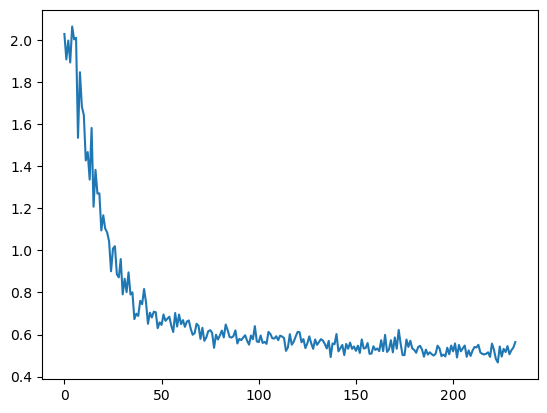

In [15]:
# plot losses
plt.plot(clf.history['loss'])

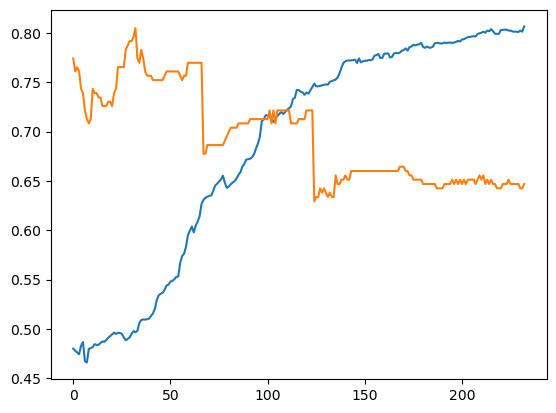

In [16]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

In [17]:
# # plot learning rates
# plt.plot(clf.history['lr'])

In [21]:
preds = clf.predict_proba(X_test)

In [22]:
preds[:,1]

array([0.2096892 , 0.20822164, 0.757488  , 0.64182264, 0.21088447,
       0.9357489 , 0.24671084, 0.24671084, 0.8065246 , 0.2603445 ,
       0.2602496 , 0.7977201 , 0.2434539 , 0.24293181, 0.8298142 ,
       0.29327103, 0.94953156, 0.29405203, 0.9450084 , 0.28200865,
       0.9466776 , 0.6962441 , 0.19204365, 0.70157516, 0.24330144,
       0.8043105 , 0.21324553, 0.6485599 ], dtype=float32)

In [20]:
array([0.3023238 , 0.29481164, 0.6596544 , 0.16191597, 0.58054733,
       0.07751235, 0.34905267, 0.34905267, 0.04242295, 0.2618657 ,
       0.37848458, 0.60709375, 0.37731048, 0.3571103 , 0.07617825,
       0.3671346 , 0.51688576, 0.36374867, 0.21771677, 0.4385563 ,
       0.07817154, 0.05496081, 0.31844085, 0.00509955, 0.3742678 ,
       0.79135275, 0.8720417 , 0.36126837], dtype=float32)

NameError: name 'array' is not defined